In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from datasets import Dataset

In [4]:

# Your original base model path where tokenizer is saved
tokenizer_path = "/Users/prasanthkumar/Desktop/Course_Work/Spring_2025/ML/Project_Final/Hugging_Face_Model"

# Your fine-tuned checkpoint path
model_checkpoint_path = "/Users/prasanthkumar/Desktop/Course_Work/Spring_2025/ML/Project_Final/Data/results/checkpoint-3702"

# Detect device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load tokenizer from base model (has tokenizer files)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, trust_remote_code=True)

# Load model from fine-tuned checkpoint
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_path, trust_remote_code=True).to(device)
model.eval()

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(4105, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1002, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-23): 24 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,), eps=1e-12, elementwise_affine=True)
          )


In [10]:
# Paths
checkpoint_path = "/Users/prasanthkumar/Desktop/Course_Work/Spring_2025/ML/Project_Final/Data/results/checkpoint-3702"
tokenizer_path = "/Users/prasanthkumar/Desktop/Course_Work/Spring_2025/ML/Project_Final/Hugging_Face_Model"
test_csv = "/Users/prasanthkumar/Desktop/Course_Work/Spring_2025/ML/Project_Final/Data/test.csv"

In [11]:
# Load tokenizer and model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path, trust_remote_code=True).to(device)
model.eval()

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(4105, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1002, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-23): 24 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,), eps=1e-12, elementwise_affine=True)
          )


In [12]:
# Load test data
df = pd.read_csv(test_csv)
dataset = Dataset.from_pandas(df)

In [13]:
# Tokenize
dataset = dataset.map(lambda x: tokenizer(x["sequence"], truncation=True, padding="max_length", max_length=512), batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

Map: 100%|█████████████████████████| 2095/2095 [00:00<00:00, 2847.86 examples/s]


In [14]:
# Predict
preds = []
true_labels = df["label"].tolist()
for i in range(len(dataset)):
    inputs = {k: v.unsqueeze(0).to(device) for k, v in dataset[i].items()}
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
        preds.append(pred)

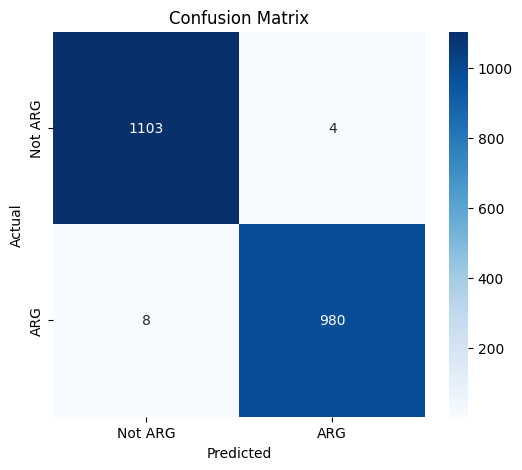

In [15]:
# --- 🔷 Plot Confusion Matrix ---
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not ARG", "ARG"], yticklabels=["Not ARG", "ARG"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
# --- 🔷 Classification Report ---
print("Classification Report:")
print(classification_report(true_labels, preds, target_names=["Not ARG", "ARG"]))

Classification Report:
              precision    recall  f1-score   support

     Not ARG       0.99      1.00      0.99      1107
         ARG       1.00      0.99      0.99       988

    accuracy                           0.99      2095
   macro avg       0.99      0.99      0.99      2095
weighted avg       0.99      0.99      0.99      2095



In [17]:
# --- 🔷 Plot Accuracy & F1 over Epochs from trainer_state.json ---
trainer_state_path = os.path.join(checkpoint_path, "trainer_state.json")
with open(trainer_state_path) as f:
    trainer_data = json.load(f)

log_history = trainer_data["log_history"]
train_loss = [x["loss"] for x in log_history if "loss" in x]
eval_acc = [x["eval_accuracy"] for x in log_history if "eval_accuracy" in x]
eval_f1 = [x["eval_f1"] for x in log_history if "eval_f1" in x]
epochs = list(range(1, len(eval_acc) + 1))

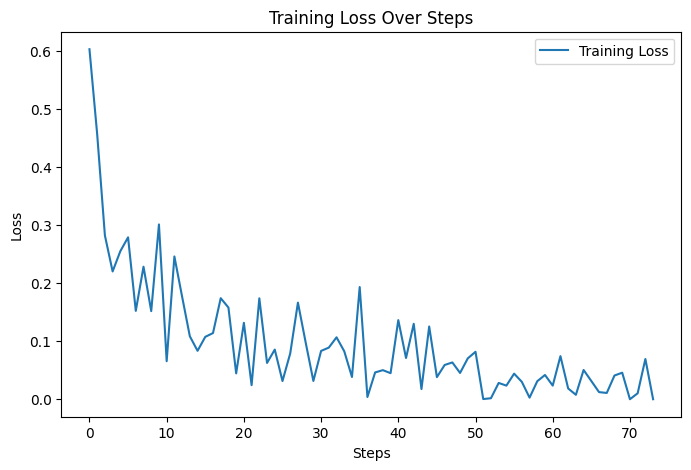

In [18]:
# --- 🔷 Plot Train Loss ---
plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.legend()
plt.show()

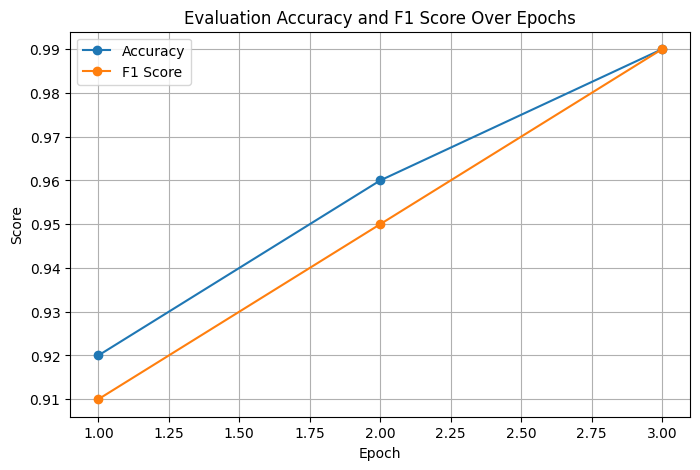

In [21]:
import matplotlib.pyplot as plt

# These should be lists of accuracy and f1 score after each epoch
# For example, if you trained for 3 epochs:
eval_acc = [0.92, 0.96, 0.99]
eval_f1 = [0.91, 0.95, 0.99]
epochs = list(range(1, len(eval_acc) + 1))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, eval_acc, marker='o', label="Accuracy")
plt.plot(epochs, eval_f1, marker='o', label="F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Evaluation Accuracy and F1 Score Over Epochs")
plt.legend()
plt.grid(True)
plt.show()